# Vardis Georgilas

In [ ]:
!pip install selenium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 23.7 MB/s eta 0:00:00


# Συλλογή Συνδέσμων Αποφάσεων από Άρειο Πάγο (2024)

Σε αυτό το κομμάτι κώδικα:

- Δημιουργούμε έναν headless Firefox browser μέσω Selenium.
- Ανοίγουμε την ιστοσελίδα του Αρείου Πάγου με τις αποφάσεις.
- Συμπληρώνουμε αυτόματα το πεδίο "Έτος" με το 2024.
- Υποβάλλουμε τη φόρμα αναζήτησης.
- Γίνεται scraping της σελίδας αποτελεσμάτων για να συλλέξουμε όλους τους συνδέσμους των αποφάσεων (`links`).
- Οι σύνδεσμοι αποθηκεύονται σε μία λίστα `links` για επεξεργασία.

Ο κώδικας χρησιμοποιεί:
- Selenium για πλοήγηση και αλληλεπίδραση με τη σελίδα.
- BeautifulSoup για ανάλυση και εξαγωγή των συνδέσμων.


In [ ]:
import time, re, pandas as pd
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup

options = Options()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)
driver.get("https://areiospagos.gr/nomologia/apofaseis.asp")

time.sleep(2)

etos_input = driver.find_element("name", "x_ETOS")
etos_input.clear()
etos_input.send_keys("2024")


# Υποβολή της φόρμας (κουμπί "Αναζήτηση")
driver.find_element("name", "submit_krit").click()
time.sleep(2)


soup = BeautifulSoup(driver.page_source, 'html.parser')
sections = soup.find_all('a', class_='blue10_cursor')

base_url = "https://areiospagos.gr/nomologia/"
links = []

for a in sections:
    href = a.get("href")
    if "apofaseis_DISPLAY.asp" in href:
        if href.startswith("apofaseis_DISPLAY.asp"):
            links.append(base_url + href)
        elif "apofaseis_result.asp" in href:
            fixed = href.split("apofaseis_DISPLAY.asp")[-1]
            links.append(base_url + "apofaseis_DISPLAY.asp" + fixed)

print(len(links))


2412


# Συναρτήσεις για Εξαγωγή Νομικών Δεδομένων


- **Συναρτήσεις**:
  - `extract_decision_info(text)`: Εξάγει αριθμό, έτος και είδος απόφασης από τον τίτλο.
  - `extract_judges(text)`: Εξάγει τα ονόματα των δικαστών από το κείμενο.
  - `extract_section(text, start_keyword, end_keyword)`: Κόβει τμήματα κειμένου ανάμεσα σε δύο λέξεις-κλειδιά.
  - `extract_criminal_articles(text)`: Βρίσκει άρθρα του Ποινικού Κώδικα (ΠΚ) και του Κώδικα Ποινικής Δικονομίας (ΚΠΔ).
  - `extract_civil_articles(text)`: Βρίσκει άρθρα του Αστικού Κώδικα (ΑΚ) και του Κώδικα Πολιτικής Δικονομίας (ΚΠολΔ).


In [ ]:
import re
import time
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

def extract_decision_info(text):
    """
    Εξάγει τον αριθμό και το έτος της απόφασης και το type_info
    από ένα κομμάτι κειμένου που περιέχει γραμμένη τη φράση:
      Απόφαση <num> / <year> (…)
    """
    match = re.search(r"Απόφαση\s+(\d+)\s*/\s*(\d+)\s*\(\s*([^)]+)\s*\)", text)
    if match:
        return match.group(1), match.group(2), match.group(3).strip()
    return "N/A", "N/A", "N/A"

def extract_judges(text):
    """
    Εξάγει το κομμάτι μετά το 'Συγκροτήθηκε από τους:' μέχρι το επόμενο newline ή τελεία.
    """
    match = re.search(r"Συγκροτήθηκε από τους δικαστές,\s*(.*?)(?:\n|\.|$)", text, re.DOTALL)
    if match:
        raw = match.group(1).strip()

        return re.sub(r"\s+", " ", raw)
    return "N/A"

def extract_section(text, start_keyword, end_keyword=None):
    """
    Κόβει το κομμάτι του text από start_keyword μέχρι end_keyword (ή μέχρι τέλους).
    """
    try:
        start = text.index(start_keyword)
        end = text.index(end_keyword) if end_keyword else len(text)
        return text[start:end].strip()
    except ValueError:
        return ""

def extract_criminal_articles(text):

    pk_pattern = re.findall(
        r"(?:άρθρο|άρθρ)\.?[\s]*(\d+(?:-\d+)?(?:\s*παρ\.?\s*\d+[α-ω]?)?)\s*(?=του\s*ΠΚ|του\s*Ποινικού\s*Κώδικα|ΠΚ|Ποινικού\s*Κώδικα)",
        text,
        re.IGNORECASE
    )

    kpd_pattern = re.findall(
        r"(?:άρ\.?|άρθρ\.?)?\s*(\d+(?:-\d+)?(?:\s*παρ\.?\s*\d+[α-ω]?)?)\s*(?=ΚΠΔ|Κώδικα Ποινικής Δικονομίας)", text, re.IGNORECASE)

    return [a.strip() for a in pk_pattern], [a.strip() for a in kpd_pattern]


def extract_civil_articles(text):
    ak_pattern = re.findall(
        r"(?:άρ\.?|άρθρ\.?)?\s*(\d+(?:-\d+)?(?:\s*παρ\.?\s*\d+[α-ω]?)?)\s*(?=Α\.Κ\.|Αστικού Κώδικα)",
        text, re.IGNORECASE)

    kpld_pattern = re.findall(
        r"(?:άρ\.?|άρθρ\.?)?\s*(\d+(?:-\d+)?(?:\s*παρ\.?\s*\d+[α-ω]?)?)\s*(?=ΚΠολΔ|Κώδικα Πολιτικής Δικονομίας)",
        text, re.IGNORECASE)

    return [a.strip() for a in ak_pattern], [a.strip() for a in kpld_pattern]



Η παρακάτω συνάρτηση αναλαμβάνει να επισκεφθεί τη σελίδα μίας απόφασης του Αρείου Πάγου και να εξάγει τα ακόλουθα δεδομένα:

- **Βασικά Στοιχεία Απόφασης**:
  - Αριθμός και Έτος Απόφασης
  - Τμήμα (Πολιτικό ή Ποινικό) και Επιμέρους Δικαστικό Τμήμα (π.χ. Β1)

- **Τίτλος Απόφασης**:
  - Καθαρίζεται από περιττές παρενθέσεις.

- **Δικαστές**:
  - Ονόματα των δικαστών που συγκροτούν το δικαστήριο.


- **Άρθρα Νομοθεσίας**:
  - Ανάλογα με το τμήμα (Πολιτικό ή Ποινικό) εντοπίζονται τα σχετικά άρθρα:
    - Ποινικός Κώδικας (ΠΚ) και Κώδικας Ποινικής Δικονομίας (ΚΠΔ)
    - Αστικός Κώδικας (ΑΚ) και Κώδικας Πολιτικής Δικονομίας (ΚΠολΔ)

Η συνάρτηση επιστρέφει όλα τα δεδομένα σε μορφή λεξικού, έτοιμα για μετατροπή σε JSON ή DataFrame.


In [ ]:


def scrape_decision(driver, url):
    driver.get(url)
    time.sleep(2)


    soup = BeautifulSoup(driver.page_source, 'html.parser')

    full_text = soup.get_text(separator="\n")

    decision_number, decision_year, type_info = extract_decision_info(full_text)

    department = None
    chamber = None
    if type_info:
        parts = type_info.split(",")
        if len(parts) > 1:
            chamber = parts[0].strip()  # π.χ. Β1
            department_info = parts[1].strip()  # π.χ. ΠΟΛΙΤΙΚΕΣ
        else:
            department_info = parts[0].strip() if parts else "N/A"
            chamber = "N/A"

        if "ΠΟΛΙΤΙΚΕΣ" == department_info:
            department = "Πολιτικό"
        elif "ΠΟΙΝΙΚΕΣ" == department_info :
            department = "Ποινικό"
        else:
            department = department_info


    title = soup.title.string.strip()
    title = re.sub(r'\(.*?\)', '', title)

    judges = extract_judges(full_text)

    court_intro     = extract_section(full_text,
                                      "ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ",
                                      "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ")
    legal_reasoning = extract_section(full_text,
                                      "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ",
                                      "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ")
    decision_end    = extract_section(full_text,
                                      "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ",
                                      None)

    if department == "Ποινικό":
        articles_PK, articles_KPD = extract_criminal_articles(full_text)
        articles_AK, articles_KPolD = [], []
    elif department == "Πολιτικό":
        articles_AK, articles_KPolD = extract_civil_articles(full_text)
        articles_PK, articles_KPD = [], []
    else:
        articles_PK = articles_KPD = articles_AK = articles_KPolD = []

    return {
        "url": url,
        "title": title,
        "department": department,
        "chamber": chamber,
        "decision_number": f"{decision_number}/{decision_year}" if decision_number != "N/A" else "N/A",
        "decision_year": decision_year,
        "judges": judges,
        "court_intro": court_intro,
        "legal_reasoning": legal_reasoning,
        "decision_end": decision_end,
        "articles_PK": articles_PK,
        "articles_KPD": articles_KPD,
        "articles_AK": articles_AK,
        "articles_KPolD": articles_KPolD
    }

# Συλλογή και Ανάλυση Δεδομένων Αποφάσεων

Σε αυτό το τμήμα πραγματοποιούνται:

- **Web Scraping**:
  - Εκκίνηση του Selenium WebDriver σε headless mode.
  - Επίσκεψη όλων των συνδέσμων αποφάσεων (`links`) και εξαγωγή δεδομένων μέσω της `scrape_decision`.
  - Καταγραφή τυχόν σφαλμάτων ανά link.

- **Αποθήκευση Δεδομένων**:
  - Τα συλλεγμένα δεδομένα αποθηκεύονται σε αρχείο `decisions.json` σε μορφή JSON.
  - Μετατροπή των δεδομένων σε Pandas DataFrame.
  - Εξαγωγή του DataFrame σε αρχείο CSV (`decisions.csv`) για ευκολότερη ανάλυση.

- **Πρώτη Ανάλυση**:
  - Εμφάνιση της κατανομής αποφάσεων ανά τμήμα (Πολιτικό ή Ποινικό).



In [ ]:

options = Options()
options.add_argument("--headless")
driver = webdriver.Firefox(options=options)

all_data = []
for link in tqdm(links):
    try:
        rec = scrape_decision(driver, link)
        all_data.append(rec)
    except Exception as e:
        print(f"[ERROR] στο {link}: {e}")

driver.quit()

with open("decisions.json", "w", encoding="utf-8") as f:
    json.dump(all_data, f, ensure_ascii=False, indent=4)

df = pd.DataFrame(all_data)
df.to_csv("decisions.csv", index=False, encoding="utf-8")

print("Number of decisions per department:")
print(df["department"].value_counts())




100%|██████████| 2412/2412 [2:01:11<00:00,  3.01s/it]


Number of decisions per department:
department
Πολιτικό              1677
Ποινικό                720
Νόμου 3068               8
N/A                      5
Πράξεις Νόμου 4842       2
Name: count, dtype: int64


# Οπτικοποίηση Δεδομένων

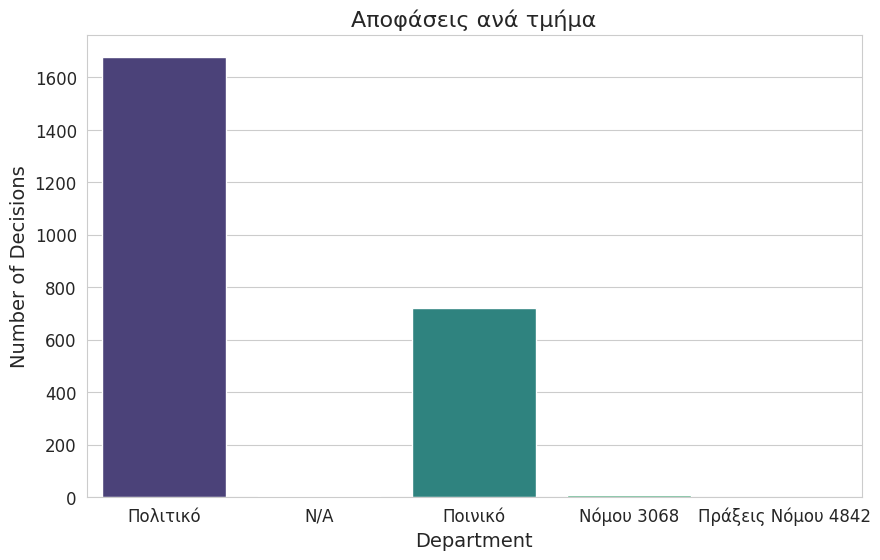

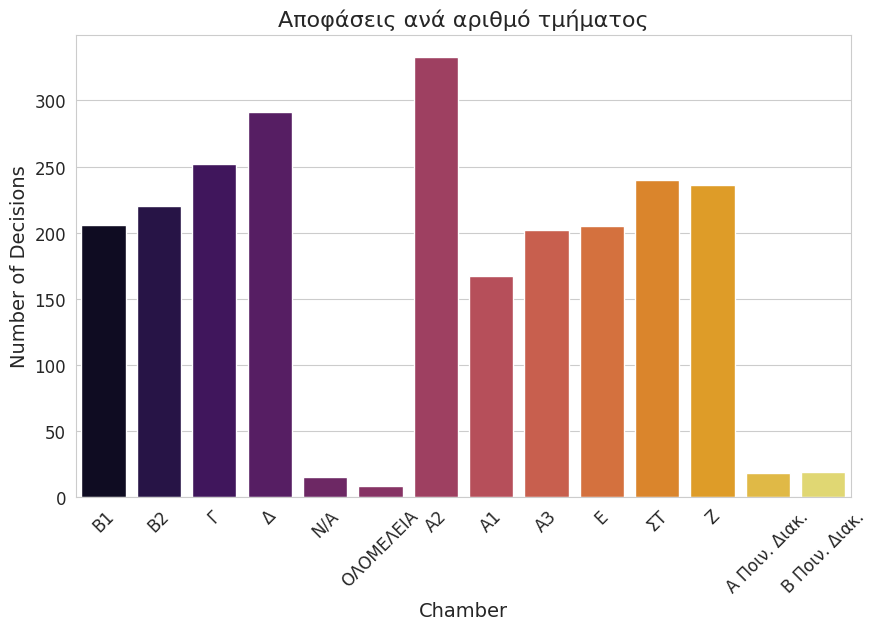

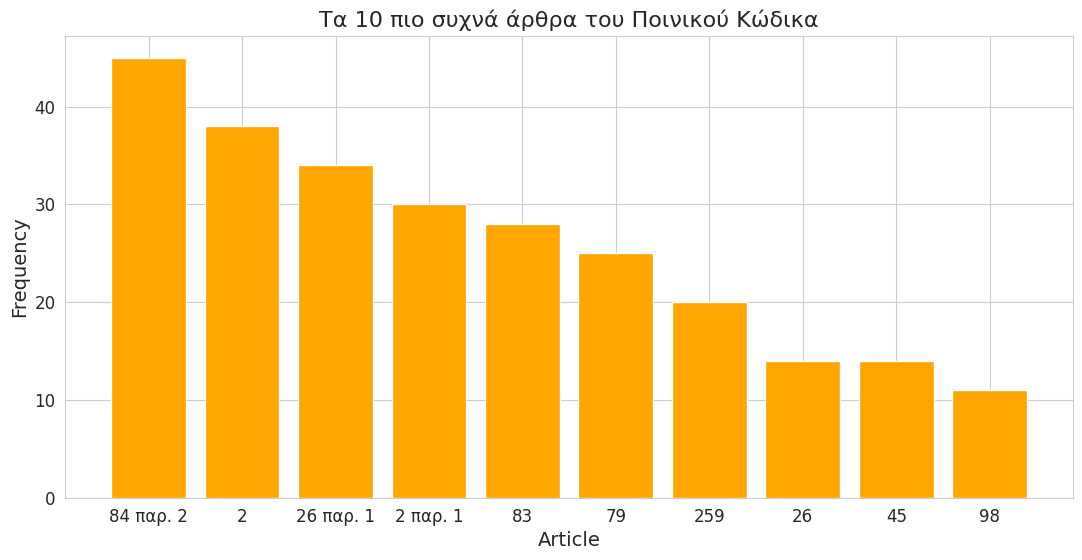

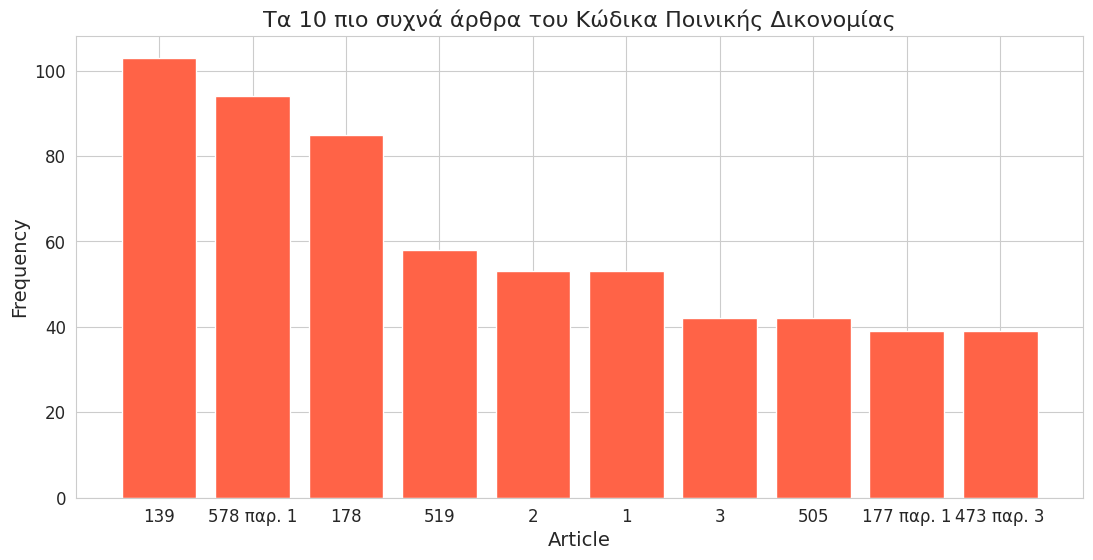

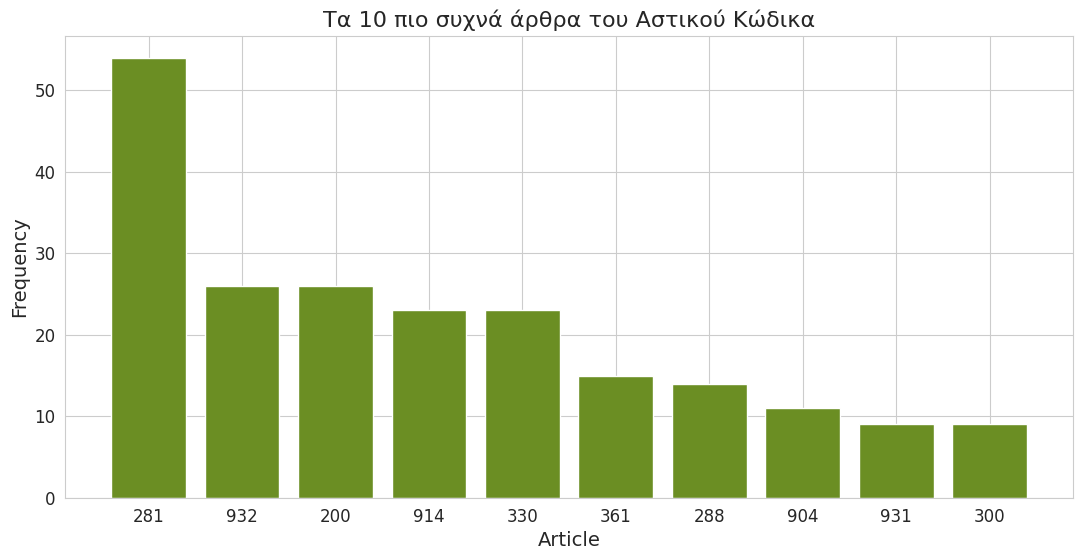

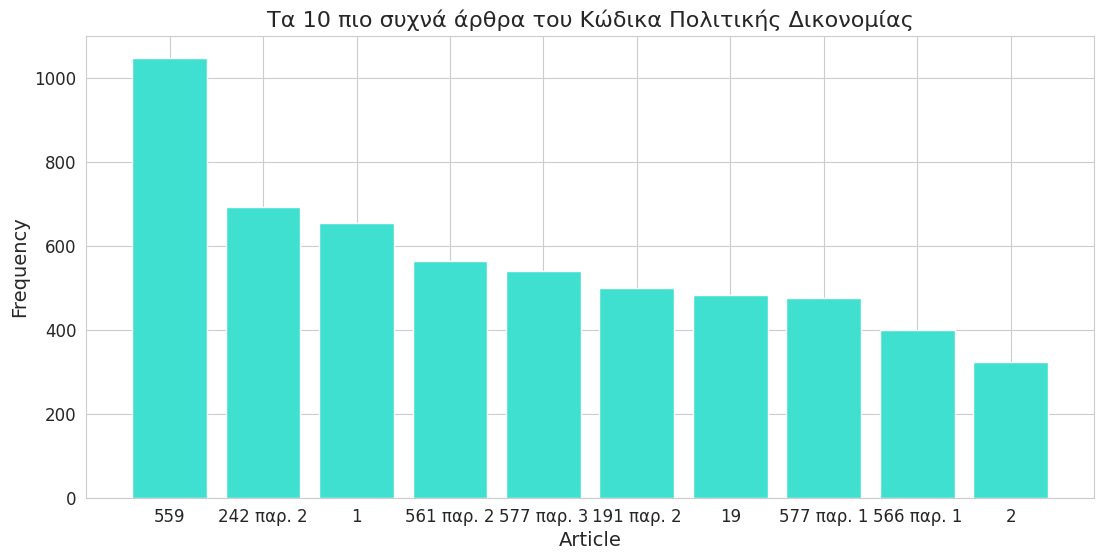

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart for department
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='department', hue='department', palette='viridis', legend=False)
plt.title('Αποφάσεις ανά τμήμα')
plt.xlabel('Department')
plt.ylabel('Number of Decisions')
plt.savefig('department_bar.png')
plt.show()
plt.close()

# Bar chart for chamber
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='chamber', hue='chamber', palette='inferno', legend=False)
plt.title('Αποφάσεις ανά αριθμό τμήματος')
plt.xlabel('Chamber')
plt.ylabel('Number of Decisions')
plt.xticks(rotation=45)
plt.savefig('chamber_bar.png')
plt.show()
plt.close()

from collections import Counter

def plot_top_articles(article_list, title, color, filename):
    # Remove duplicates within each row
    unique_articles_per_row = [set(sublist) for sublist in article_list]
    # flatten
    flat_articles = [item for sublist in unique_articles_per_row for item in sublist]
    article_counts = Counter(flat_articles)
    top_articles = article_counts.most_common(10)

    plt.figure(figsize=(13, 6))
    plt.bar([str(a[0]) for a in top_articles], [a[1] for a in top_articles], color=color)
    plt.title(title)
    plt.xlabel('Article')
    plt.ylabel('Frequency')
    plt.savefig(filename)
    plt.show()
    plt.close()

plot_top_articles(df['articles_PK'], 'Τα 10 πιο συχνά άρθρα του Ποινικού Κώδικα', 'orange', 'articles_PK_bar.png')
plot_top_articles(df['articles_KPD'], 'Τα 10 πιο συχνά άρθρα του Κώδικα Ποινικής Δικονομίας', 'tomato', 'articles_KPD_bar.png')
plot_top_articles(df['articles_AK'], 'Τα 10 πιο συχνά άρθρα του Αστικού Κώδικα', 'olivedrab', 'articles_AK_bar.png')
plot_top_articles(df['articles_KPolD'], 'Τα 10 πιο συχνά άρθρα του Κώδικα Πολιτικής Δικονομίας', 'turquoise', 'articles_KPolD_bar.png')

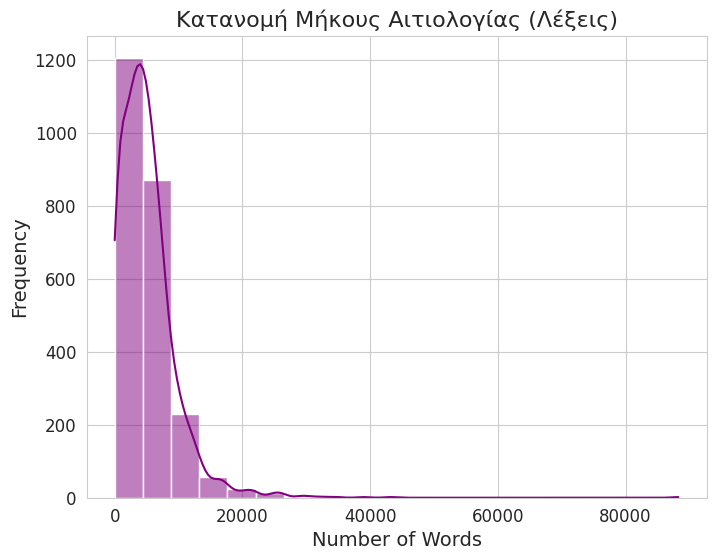

In [ ]:
df['legal_reasoning_length'] = df['legal_reasoning'].apply(lambda x: len(x.split()) if x else 0)

plt.figure(figsize=(8, 6))
sns.histplot(df['legal_reasoning_length'], bins=20, kde=True, color='purple')
plt.title('Κατανομή Μήκους Αιτιολογίας (Λέξεις)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.savefig('legal_reasoning_hist.png')
plt.show()
plt.close()




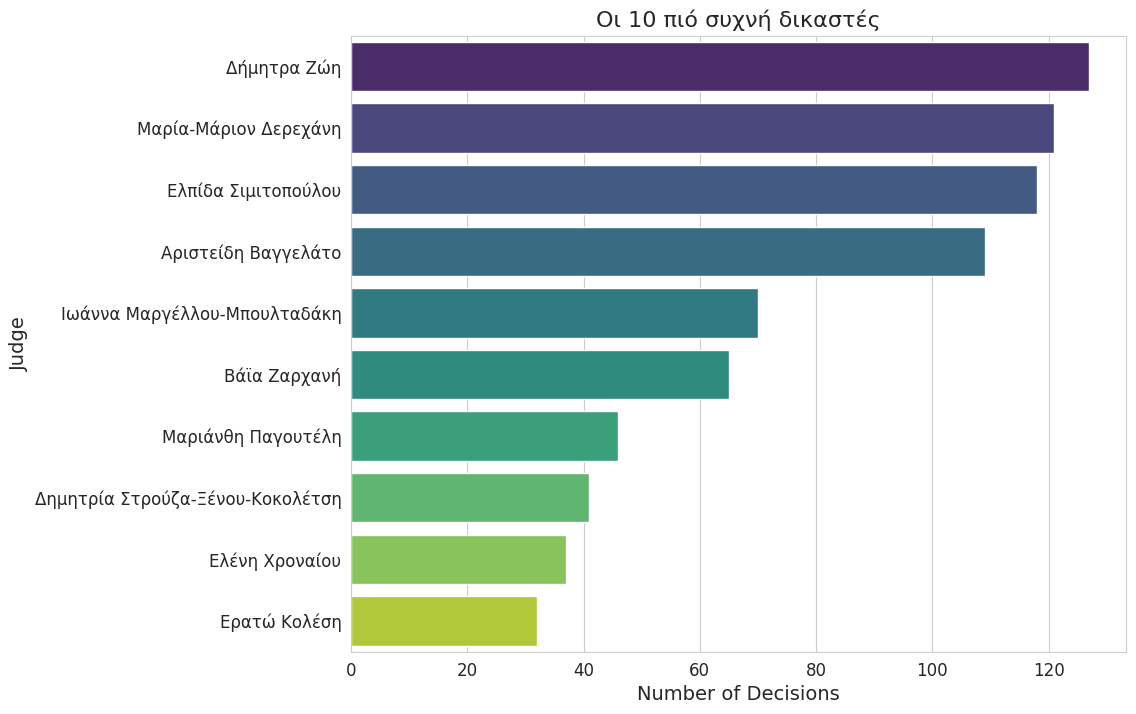

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# extract judge names from a single row
def extract_judges(judges_str):
    names = []
    parts = [part.strip() for part in judges_str.split(',')]
    for part in parts:
        if 'και' in part:
            subparts = [sub.strip() for sub in part.split('και')]
            for sub in subparts:
                if sub and len(sub.split()) == 2:
                    names.append(sub)
        else:
            if len(part.split()) == 2:
                names.append(part)
    return names

all_judges = []
for judges_str in df['judges']:
    all_judges.extend(extract_judges(judges_str))

# Count frequency of each judge
judge_counts = Counter(all_judges)
top_judges = judge_counts.most_common(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=[j[1] for j in top_judges], y=[j[0] for j in top_judges], hue=[j[0] for j in top_judges], palette='viridis', legend=False)
plt.title('Οι 10 πιό συχνή δικαστές')
plt.xlabel('Number of Decisions')
plt.ylabel('Judge')
plt.savefig('judges_bar.png')
plt.show()
plt.close()